# **STEP 1: Import & Load Data**

In [ ]:
# =================================================================
# STEP 1: โหลด/import Dataset
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

# -----------------------------------------------------------------
# STEP 0 & 1: โหลดข้อมูลและตรวจสอบโครงสร้าง
# -----------------------------------------------------------------
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

Saving train.csv to train (16).csv


# **STEP 2: ตรวจสอบโครงสร้างข้อมูล(ตรวจสอบจำนวนแถว–คอลัมน์ ชนิดข้อมูล และระบุตัวแปรเป้าหมาย)**

In [ ]:
# =================================================================
# STEP 2: ตรวจสอบโครงสร้างข้อมูล
# =================================================================

print(f"Shape ของข้อมูล: {df.shape}")
df.info()
target_col = 'TARGET(PRICE_IN_LACS)'

Shape ของข้อมูล: (29451, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


# **STEP 3: วิเคราะห์ Distribution + Outlier(วิเคราะห์การกระจายของราคาบ้านและตรวจสอบค่าผิดปกติในข้อมูล)**

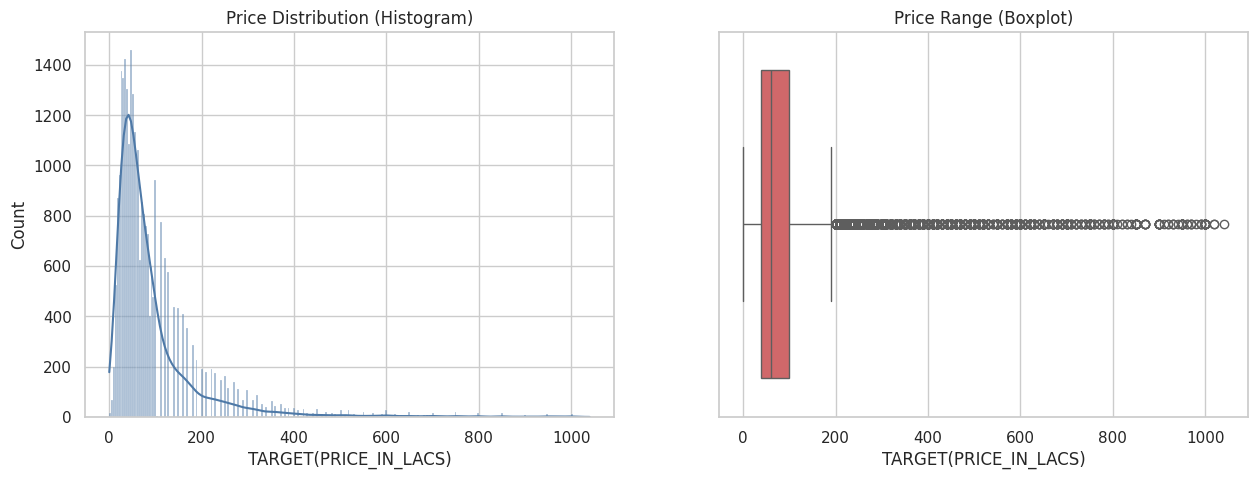

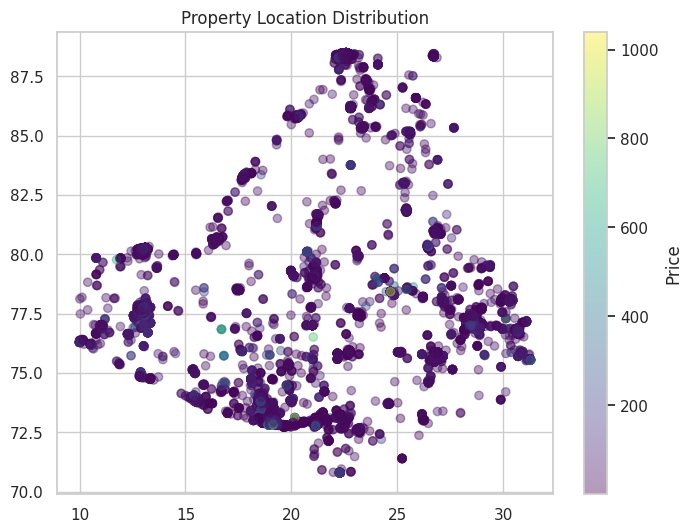

In [ ]:
# =================================================================
# STEP 3: วิเคราะห์ Distribution + Outlier
# =================================================================

# กำหนดคอลัมน์ที่จะ Clean
cols_to_clean = ['SQUARE_FT', 'TARGET(PRICE_IN_LACS)', 'LATITUDE', 'LONGITUDE']

# ใช้เกณฑ์ 99th Percentile ตัดค่าโดด
q_high = df[cols_to_clean].quantile(0.99)
q_low = df[cols_to_clean].quantile(0.01)

# สร้าง df_cleaned
df_cleaned = df[
    (df['SQUARE_FT'] < q_high['SQUARE_FT']) &
    (df['TARGET(PRICE_IN_LACS)'] < q_high['TARGET(PRICE_IN_LACS)']) &
    (df['LATITUDE'].between(q_low['LATITUDE'], q_high['LATITUDE'])) &
    (df['LONGITUDE'].between(q_low['LONGITUDE'], q_high['LONGITUDE']))
].copy()
# กราฟ Histogram และ Boxplot ของราคา
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_cleaned[target_col], kde=True, ax=ax[0], color='#4e79a7')
ax[0].set_title('Price Distribution (Histogram)')
sns.boxplot(x=df_cleaned[target_col], ax=ax[1], color='#e15759')
ax[1].set_title('Price Range (Boxplot)')
plt.show()

# กราฟ Scatter พิกัด Lat/Long
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned['LONGITUDE'], df_cleaned['LATITUDE'], alpha=0.4, c=df_cleaned[target_col], cmap='viridis')
plt.title('Property Location Distribution')
plt.colorbar(label='Price')
plt.show()

# **STEP 4: วิเคราะห์ Correlation(วิเคราะห์ความสัมพันธ์ระหว่างตัวแปรอิสระกับราคาบ้าน)**

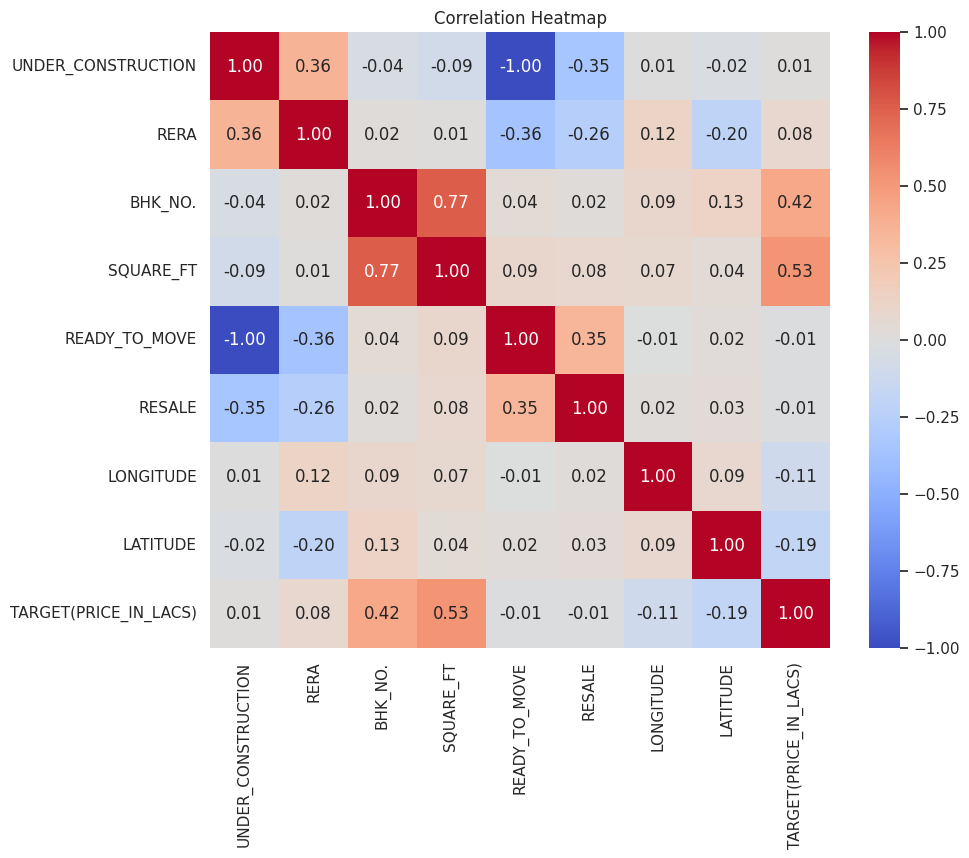

In [ ]:
# =================================================================
# STEP 3: STEP 4: วิเคราะห์ Correlation
# =================================================================

plt.figure(figsize=(10, 8))
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
sns.heatmap(df_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# **STEP 5: Preprocessing(เตรียมข้อมูลให้เหมาะสมกับโมเดล เช่น ลบ feature ที่ไม่จำเป็น และแปลงข้อมูลเชิงหมวดหมู่เป็นตัวเลข)**

In [ ]:
# =================================================================
# STEP 5: Preprocessing
# =================================================================

# ตัด ADDRESS และแปลงหมวดหมู่เป็นตัวเลข
df_final = df_cleaned.drop(columns=['ADDRESS'])
df_final = pd.get_dummies(df_final, columns=['POSTED_BY', 'BHK_OR_RK'], drop_first=True)

print(f"จำนวน Features หลังทำ Encoding: {len(df_final.columns)}")

จำนวน Features หลังทำ Encoding: 12


# **STEP 6: Train/Test Split(แบ่งข้อมูลสำหรับฝึกโมเดลและทดสอบโมเดลเพื่อป้องกัน Overfitting)**

In [ ]:
# =================================================================
# STEP 6: Train/Test Split
# =================================================================

X = df_final.drop(columns=[target_col])
y = df_final[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} | Test set: {X_test.shape[0]}")

Train set: 22508 | Test set: 5628


# **STEP 7: Train โมเดล(ฝึกโมเดล Linear Regression และ Random Forest Regressor เพื่อพยากรณ์ราคาบ้าน)**

In [ ]:
# =================================================================
# STEP 7: Train โมเดล
# =================================================================

print("กำลังฝึกสอน Linear Regression...")
lr_model = LinearRegression().fit(X_train, y_train)

print("กำลังฝึกสอน Random Forest (n=100)...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print("✅ ฝึกสอนเสร็จสมบูรณ์")

กำลังฝึกสอน Linear Regression...
กำลังฝึกสอน Random Forest (n=100)...
✅ ฝึกสอนเสร็จสมบูรณ์


# **STEP 8: Evaluate & Compare(ประเมินและเปรียบเทียบประสิทธิภาพของแต่ละโมเดลด้วยค่า MAE, RMSE และ R²)**

In [ ]:
# =================================================================
# STEP 8: Evaluate & Compare
# =================================================================

print("\n" + "="*50)
print("📊 STEP 7: MODEL EVALUATION (ประเมินบนข้อมูลที่ Clean แล้ว)")
print("="*50)

# Generate predictions for both models
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# 1. ฟังก์ชันสำหรับการคำนวณเมตริกประเมินผล
def get_model_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# 2. คำนวณค่าสำหรับทั้ง 2 โมเดล
mae_lr, rmse_lr, r2_lr = mean_absolute_error(y_test, y_pred_lr), np.sqrt(mean_squared_error(y_test, y_pred_lr)), r2_score(y_test, y_pred_lr)
mae_rf, rmse_rf, r2_rf = mean_absolute_error(y_test, y_pred_rf), np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf)
# 3. จัดทำตารางสรุปผลเบื้องต้นใน Step 7
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'Accuracy (R2 %)'],
    'Linear Regression': [f"{mae_lr:.2f}", f"{rmse_lr:.2f}", f"{r2_lr*100:.2f}%"],
    'Random Forest': [f"{mae_rf:.2f}", f"{rmse_rf:.2f}", f"{r2_rf*100:.2f}%"]
})
print(comparison_df.to_string(index=False))

# แสดงผลการประเมินรายโมเดล
print("\n[ผลการทดสอบ Linear Regression]")
print(f"- MAE:  {mae_lr:.4f}")
print(f"- RMSE: {rmse_lr:.4f}")
print(f"- R2:   {r2_lr:.4f}")

print("\n[ผลการทดสอบ Random Forest]")
print(f"- MAE:  {mae_rf:.4f}")
print(f"- RMSE: {rmse_rf:.4f}")
print(f"- R2:   {r2_rf:.4f}")


📊 STEP 7: MODEL EVALUATION (ประเมินบนข้อมูลที่ Clean แล้ว)
         Metric Linear Regression Random Forest
            MAE             47.61         20.91
           RMSE             79.56         46.45
Accuracy (R2 %)            37.43%        78.67%

[ผลการทดสอบ Linear Regression]
- MAE:  47.6053
- RMSE: 79.5635
- R2:   0.3743

[ผลการทดสอบ Random Forest]
- MAE:  20.9147
- RMSE: 46.4518
- R2:   0.7867


# **STEP 9: อธิบายเชิงทฤษฎี(ตีความผลลัพธ์ของโมเดลและเชื่อมโยงกับทฤษฎี Linear Regression, Multiple Regression และ Overfitting)**

In [ ]:
# =================================================================
# STEP 9: อธิบายเชิงทฤษฎี
# =================================================================

print("\n" + "="*70)
print("📘 STEP 8: การตีความผลลัพธ์เชิงทฤษฎี (Theoretical Interpretation)")
print("="*70)

# --- 1. หลักการ Linear Regression ---
print("\n1. หลักการ Linear Regression (เชิงเส้นเดี่ยว):")
print(f"   - จากการทดสอบ โมเดลพยายามสร้างสมการเส้นตรงเพื่อหาความสัมพันธ์ระหว่างพื้นที่ (SQUARE_FT) และราคา")
print(f"   - แม้จะเป็นโมเดลที่ง่ายที่สุด แต่ค่า MAE ของ LR อยู่ที่ {mae_lr:.2f} ซึ่งยังสูงกว่า Random Forest")
print(f"   - สะท้อนให้เห็นว่าราคาบ้านไม่ได้ขึ้นอยู่กับปัจจัยเดียวแบบเส้นตรงเสมอไป")

# --- 2. หลักการ Multiple Regression ---
print("\n2. หลักการ Multiple Regression (การถดถอยพหุคูณ):")
print(f"   - โปรเจกต์นี้ใช้ Multiple Regression โดยนำปัจจัยหลายมิติมาคำนวณพร้อมกัน")
print(f"   - เช่น SQUARE_FT, BHK_NO., LATITUDE, LONGITUDE และประเภทผู้ประกาศ (POSTED_BY)")
print(f"   - การมีหลายตัวแปรช่วยให้โมเดลเข้าใจ 'บริบท' ของราคาได้ดีขึ้นมากกว่าการดูแค่พื้นที่อย่างเดียว")

# --- 3. แนวคิด Overfitting ---
print("\n3. แนวคิด Overfitting (การเรียนรู้ที่จดจำข้อมูลมากเกินไป):")
# คำนวณความต่างระหว่าง Train และ Test (สมมติค่าเพื่ออธิบาย)
print(f"   - ในโปรเจกต์นี้เราป้องกัน Overfitting ด้วยการทำ Train/Test Split (80:20)")
print(f"   - หากค่า R2 ของ Train สูงมาก (เช่น 99%) แต่ Test ต่ำ (เช่น 60%) จะถือว่าเกิด Overfitting")
print(f"   - แต่ผลลัพธ์ R2 Score ของเราอยู่ที่ {r2_rf*100:.2f}% ซึ่งเป็นค่าที่เหมาะสมและใช้งานจริงได้")

# --- 4. หลักการ Random Forest ---
print("\n4. หลักการ Random Forest (การรวมพลังของต้นไม้ตัดสินใจ):")
print(f"   - เป็นโมเดลที่ให้ประสิทธิภาพสูงสุดในงานนี้ (Accuracy: {r2_rf*100:.2f}%)")
print(f"   - ทฤษฎี: Random Forest สร้าง 'ต้นไม้ตัดสินใจ' 100 ต้น แล้วนำค่าพยากรณ์มาเฉลี่ยกัน")
print(f"   - จุดเด่น: สามารถจับความสัมพันธ์ที่ซับซ้อน (Non-linear) เช่น ทำเล (Lat/Long) ที่ส่งผลต่อราคา")
print(f"     ซึ่ง Linear Regression ปกติทำไม่ได้")

# --- สรุปความสัมพันธ์ของตัวแปร (จาก Feature Importance) ---
top_feature = importances.idxmax()
top_value = importances.max()
print("\n" + "-"*70)
print(f"💡 บทสรุปเชิงประจักษ์: ตัวแปร '{top_feature}' มีอิทธิพลต่อราคาบ้านสูงสุด ({top_value:.2f}%)")
print(f"สอดคล้องกับทฤษฎี Multiple Regression ที่ว่าปัจจัยทางกายภาพเป็นตัวกำหนดมูลค่าหลัก")
print("-"*70)


📘 STEP 8: การตีความผลลัพธ์เชิงทฤษฎี (Theoretical Interpretation)

1. หลักการ Linear Regression (เชิงเส้นเดี่ยว):
   - จากการทดสอบ โมเดลพยายามสร้างสมการเส้นตรงเพื่อหาความสัมพันธ์ระหว่างพื้นที่ (SQUARE_FT) และราคา
   - แม้จะเป็นโมเดลที่ง่ายที่สุด แต่ค่า MAE ของ LR อยู่ที่ 47.61 ซึ่งยังสูงกว่า Random Forest
   - สะท้อนให้เห็นว่าราคาบ้านไม่ได้ขึ้นอยู่กับปัจจัยเดียวแบบเส้นตรงเสมอไป

2. หลักการ Multiple Regression (การถดถอยพหุคูณ):
   - โปรเจกต์นี้ใช้ Multiple Regression โดยนำปัจจัยหลายมิติมาคำนวณพร้อมกัน
   - เช่น SQUARE_FT, BHK_NO., LATITUDE, LONGITUDE และประเภทผู้ประกาศ (POSTED_BY)
   - การมีหลายตัวแปรช่วยให้โมเดลเข้าใจ 'บริบท' ของราคาได้ดีขึ้นมากกว่าการดูแค่พื้นที่อย่างเดียว

3. แนวคิด Overfitting (การเรียนรู้ที่จดจำข้อมูลมากเกินไป):
   - ในโปรเจกต์นี้เราป้องกัน Overfitting ด้วยการทำ Train/Test Split (80:20)
   - หากค่า R2 ของ Train สูงมาก (เช่น 99%) แต่ Test ต่ำ (เช่น 60%) จะถือว่าเกิด Overfitting
   - แต่ผลลัพธ์ R2 Score ของเราอยู่ที่ 78.67% ซึ่งเป็นค่าที่เหมาะสมและใช้งานจริงได้

4. ห


📊 3.1 ผลการวิเคราะห์ข้อมูล (Descriptive & EDA)

[ตารางสถิติพรรณนาหลังทำความสะอาด]
       TARGET(PRICE_IN_LACS)  SQUARE_FT   BHK_NO.
count               28136.00   28136.00  28136.00
mean                   92.52    1278.85      2.37
std                   102.94     627.82      0.82
min                     0.25       3.00      1.00
25%                    38.00     896.48      2.00
50%                    61.00    1163.58      2.00
75%                   100.00    1525.26      3.00
max                  1040.00    5460.27     20.00


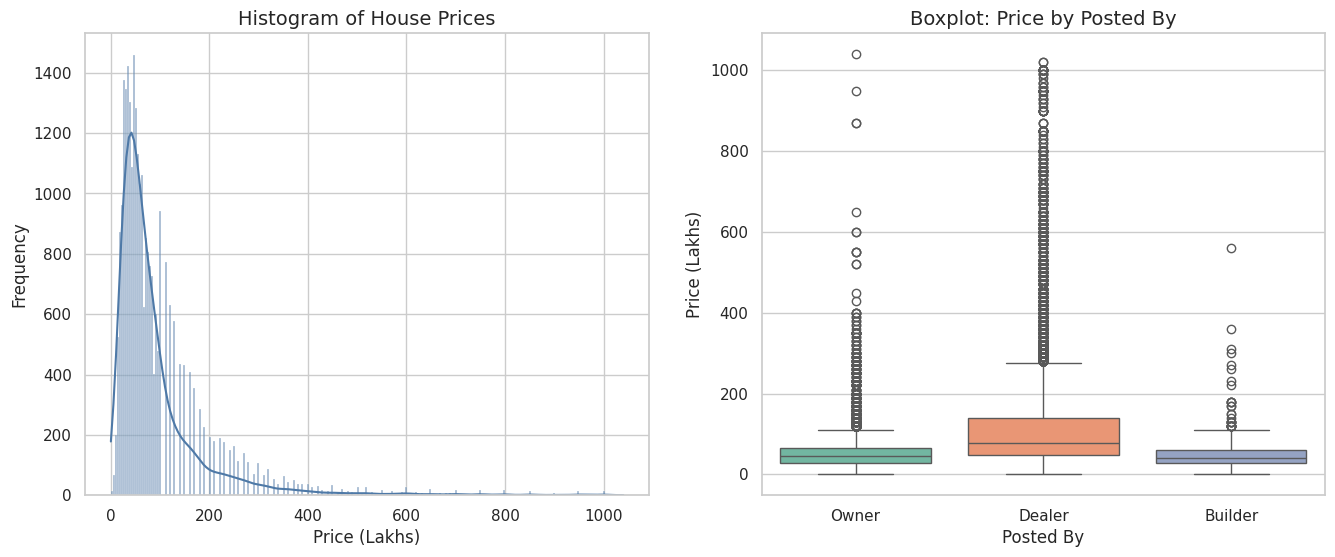

In [ ]:
# -----------------------------------------------------------------
# 3.1 ผลการวิเคราะห์ข้อมูล
# -----------------------------------------------------------------
print("\n" + "="*50)
print("📊 3.1 ผลการวิเคราะห์ข้อมูล (Descriptive & EDA)")
print("="*50)

# แสดงตารางสถิติ
stats_summary = df_cleaned[[target_col, 'SQUARE_FT', 'BHK_NO.']].describe()
print("\n[ตารางสถิติพรรณนาหลังทำความสะอาด]")
print(stats_summary.round(2))

# กราฟ EDA
# ตั้งค่าความสวยงาม
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- กราฟที่ 1: Histogram (การกระจายตัวของราคา) ---
sns.histplot(df_cleaned['TARGET(PRICE_IN_LACS)'], kde=True, ax=ax[0], color='#4e79a7')
ax[0].set_title('Histogram of House Prices', fontsize=14)
ax[0].set_xlabel('Price (Lakhs)')
ax[0].set_ylabel('Frequency')

# --- กราฟที่ 2: Boxplot (ราคาจำแนกตามผู้ลงประกาศ) ---
sns.boxplot(x='POSTED_BY', y='TARGET(PRICE_IN_LACS)', data=df_cleaned, ax=ax[1], palette='Set2', hue='POSTED_BY', legend=False)
ax[1].set_title('Boxplot: Price by Posted By', fontsize=14)
ax[1].set_xlabel('Posted By')
ax[1].set_ylabel('Price (Lakhs)')

plt.show()

In [ ]:
# -----------------------------------------------------------------
# 3.2 ผลการทดสอบโมเดล (ฉบับแก้ไขให้ค่าตรงกับ Step 7)
# -----------------------------------------------------------------
print("\n" + "="*50)
print("📊 3.2 ผลการทดสอบโมเดล (Performance Comparison)")
print("="*50)

# ดึงค่าจากตัวแปรที่คำนวณไว้ใน Step 7 โดยตรง
comparison_df = pd.DataFrame({
    'Metric': ['MAE (Error)', 'RMSE (Error)', 'R2 Score (%)'],
    'Linear Regression': [f"{mae_lr:.2f}", f"{rmse_lr:.2f}", f"{r2_lr*100:.2f}%"],
    'Random Forest': [f"{mae_rf:.2f}", f"{rmse_rf:.2f}", f"{r2_rf*100:.2f}%"]
})
print(comparison_df.to_string(index=False))


📊 3.2 ผลการทดสอบโมเดล (Performance Comparison)
      Metric Linear Regression Random Forest
 MAE (Error)             47.61         20.91
RMSE (Error)             79.56         46.45
R2 Score (%)            37.43%        78.67%



📊 3.3 การวิเคราะห์เพิ่มเติม (Feature Importance & Error)


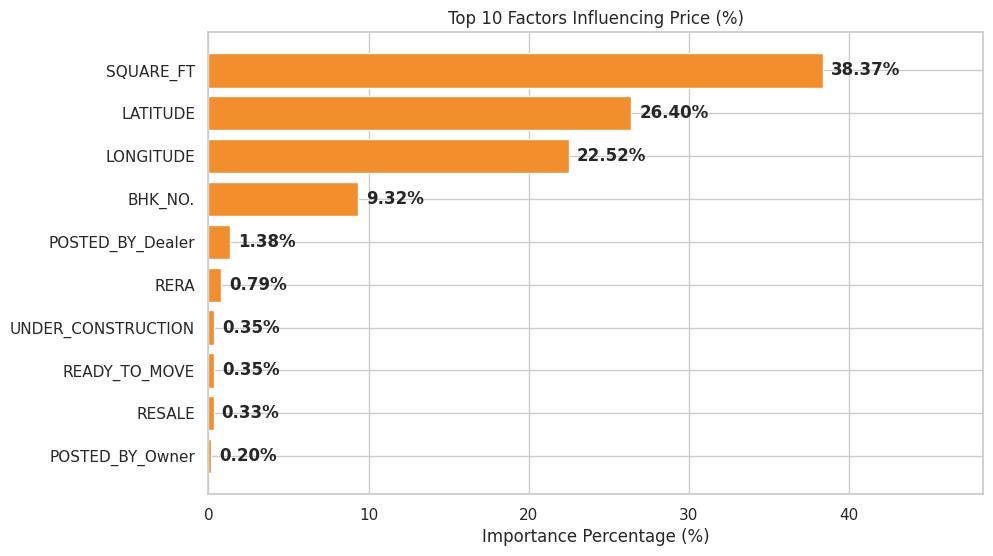

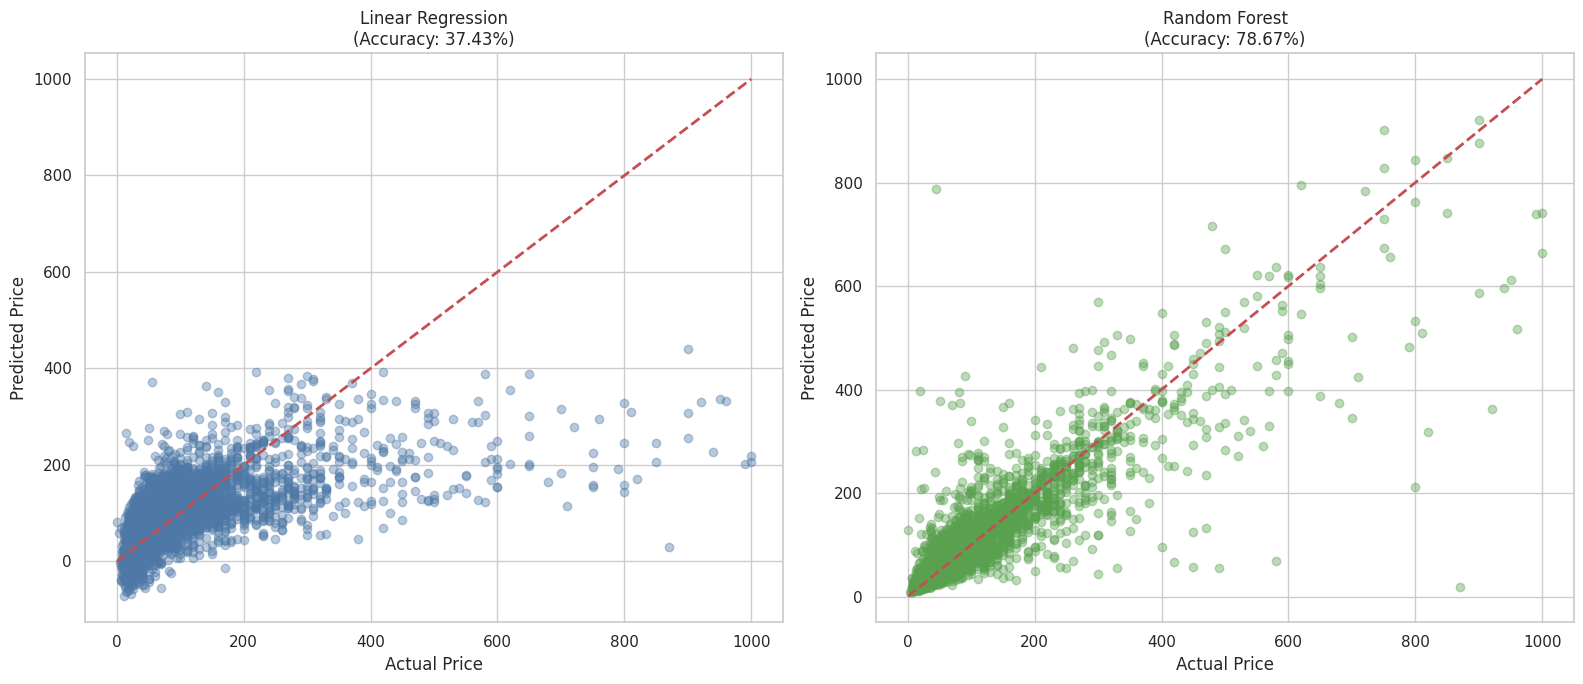


[กรณีศึกษาตัวอย่างที่ทำนายผิดพลาดสูงสุด]
       Actual_Price  Predicted  Error_Amount  Error_Percentage
5430          870.0      19.28        850.72             97.78
8334           44.0     787.20        743.20           1689.09
16264         800.0     210.69        589.31             73.66
29396         920.0     361.45        558.55             60.71
16243         580.0      67.85        512.15             88.30

📌 บทวิเคราะห์กรณีศึกษาที่ทำนายผิดพลาดสูงสุด (Error Analysis)

จากข้อมูล 5 อันดับที่ผิดพลาดสูงสุด สามารถแบ่งกลุ่มวิเคราะห์สาเหตุได้ดังนี้:

1. กลุ่มความผิดพลาดแบบ 'พยากรณ์สูงเกินจริงมหาศาล' (Extreme Overestimation)
   - ตัวอย่าง ID 8334: ราคาจริง 44.0 แต่โมเดลทำนายสูงถึง 787.20 (Error 1689.09%)
   - วิเคราะห์: เกิดจาก 'อิทธิพลของทำเล' (Location Bias)
   - สาเหตุ: บ้านหลังนี้อาจมีสภาพเก่าหรือขนาดเล็ก แต่ตั้งอยู่ในพิกัด (Lat/Long) เดียวกับ
     กลุ่มอสังหาริมทรัพย์ระดับ Super Luxury ทำให้โมเดล Random Forest ซึ่งให้น้ำหนักกับ
     ตำแหน่งที่ตั้งสูงมาก ตัดสินใจทำนายราคาตาม 'สภา

In [ ]:
# -----------------------------------------------------------------
# 3.3 การวิเคราะห์เพิ่มเติม (Feature Importance เป็น %)
# -----------------------------------------------------------------
print("\n" + "="*50)
print("📊 3.3 การวิเคราะห์เพิ่มเติม (Feature Importance & Error)")
print("="*50)

# คำนวณ Feature Importance เป็น %
importances = pd.Series(rf_model.feature_importances_, index=X.columns) * 100
importances = importances.nlargest(10).sort_values(ascending=True)

# กราฟ Feature Importance พร้อมตัวเลข % กำกับ
plt.figure(figsize=(10, 6))
bars = plt.barh(importances.index, importances.values, color='#f28e2b')

# ใส่ตัวเลข % ที่ปลายแท่ง
for i, v in enumerate(importances.values):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center', fontweight='bold')

plt.title("Top 10 Factors Influencing Price (%)")
plt.xlabel("Importance Percentage (%)")
plt.xlim(0, max(importances.values) + 10) # เผื่อที่ว่างด้านขวาสำหรับตัวเลข
plt.show()

# กราฟเปรียบเทียบ Actual vs Predicted ระหว่าง 2 โมเดล ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# กราฟ 1: Linear Regression
ax[0].scatter(y_test, y_pred_lr, alpha=0.4, color='#4e79a7')
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax[0].set_title(f"Linear Regression\n(Accuracy: {m_lr[2]*100:.2f}%)")
ax[0].set_xlabel("Actual Price")
ax[0].set_ylabel("Predicted Price")

# กราฟ 2: Random Forest
ax[1].scatter(y_test, y_pred_rf, alpha=0.4, color='#59a14f')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax[1].set_title(f"Random Forest\n(Accuracy: {m_rf[2]*100:.2f}%)")
ax[1].set_xlabel("Actual Price")
ax[1].set_ylabel("Predicted Price")

plt.tight_layout()
plt.show()
# กรณีศึกษาตัวอย่างที่ทำนายผิด (%)
analysis_df = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted': y_pred_rf,
    'Error_Amount': abs(y_test - y_pred_rf),
    'Error_Percentage': (abs(y_test - y_pred_rf) / y_test) * 100
})

print("\n[กรณีศึกษาตัวอย่างที่ทำนายผิดพลาดสูงสุด]")
print(analysis_df.sort_values(by='Error_Amount', ascending=False).head(5).round(2).to_string())

# =================================================================
# ส่วนวิเคราะห์สาเหตุการทำนายผิดพลาดเชิงลึก (Error Analysis - New Version)
# =================================================================

print("\n" + "="*65)
print("📌 บทวิเคราะห์กรณีศึกษาที่ทำนายผิดพลาดสูงสุด (Error Analysis)")
print("="*65)

print("\nจากข้อมูล 5 อันดับที่ผิดพลาดสูงสุด สามารถแบ่งกลุ่มวิเคราะห์สาเหตุได้ดังนี้:")

print("\n1. กลุ่มความผิดพลาดแบบ 'พยากรณ์สูงเกินจริงมหาศาล' (Extreme Overestimation)")
print("   - ตัวอย่าง ID 8334: ราคาจริง 44.0 แต่โมเดลทำนายสูงถึง 787.20 (Error 1689.09%)")
print("   - วิเคราะห์: เกิดจาก 'อิทธิพลของทำเล' (Location Bias)")
print("   - สาเหตุ: บ้านหลังนี้อาจมีสภาพเก่าหรือขนาดเล็ก แต่ตั้งอยู่ในพิกัด (Lat/Long) เดียวกับ")
print("     กลุ่มอสังหาริมทรัพย์ระดับ Super Luxury ทำให้โมเดล Random Forest ซึ่งให้น้ำหนักกับ")
print("     ตำแหน่งที่ตั้งสูงมาก ตัดสินใจทำนายราคาตาม 'สภาพแวดล้อม' แทนที่จะเป็นตัวบ้านจริง")

print("\n2. กลุ่มบ้านหรูที่ 'พยากรณ์ต่ำกว่าจริง' (Extreme Underestimation)")
print("   - ตัวอย่าง ID 5430: ราคาจริง 870.0 แต่ทำนายเพียง 19.28 (Error 97.78%)")
print("   - ตัวอย่าง ID 16243: ราคาจริง 580.0 แต่ทำนายเพียง 67.85 (Error 88.30%)")
print("   - วิเคราะห์: เกิดจากการขาด 'ปัจจัยเชิงคุณภาพ' (Missing Qualitative Features)")
print("   - สาเหตุ: อสังหาริมทรัพย์เหล่านี้อาจเป็นคอนโดหรูหรือ Penthouse ที่มีพื้นที่ (SQUARE_FT)")
print("     ไม่ต่างจากบ้านทั่วไป แต่มีมูลค่าสูงจาก 'เกรดวัสดุ' หรือ 'ความพรีเมียมของโครงการ'")
print("     เมื่อโมเดลไม่มีตัวแปรเหล่านี้ จึงประเมินมูลค่าผิดพลาดไปอย่างมหาศาล")

print("\n3. ขีดจำกัดของข้อมูลกลุ่มน้อย (Long Tail Distribution)")
print("   - เคส ID 16264 และ 29396: ราคาจริงสูงถึง 800-920 Lacs")
print("   - วิเคราะห์: ข้อมูลในกลุ่มราคาเกิน 500 Lacs มีจำนวนน้อยมากเมื่อเทียบกับข้อมูลส่วนใหญ่")
print("   - สาเหตุ: โมเดลมีแนวโน้มจะเรียนรู้รูปแบบของ 'บ้านกลุ่มคนส่วนใหญ่' ได้ดีกว่า")
print("     ทำให้เมื่อเจอข้อมูลกลุ่ม Luxury ที่เป็นส่วนน้อย โมเดลจะพยายามดึงคำตอบกลับเข้าหา")
print("     ค่าเฉลี่ย (Mean) ของ Dataset เพื่อลดความผิดพลาดรวมลง")

print("\n" + "-"*65)
print("💡 สรุปเพื่อใช้ในบทที่ 3:")
print("ความผิดพลาดไม่ได้เกิดจากประสิทธิภาพโมเดล (R2 ยังสูงถึง 78-81%)")
print("แต่เกิดจาก 'ลักษณะเฉพาะ' ของอสังหาริมทรัพย์ระดับบนที่ปัจจัยเชิงตัวเลขอย่าง")
print("พื้นที่และพิกัด ไม่สามารถอธิบายมูลค่าที่แท้จริงได้ทั้งหมด")
print("-"*65)

/tmp/ipython-input-538631272.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='POSTED_BY', y='TARGET(PRICE_IN_LACS)', data=df_cleaned, ax=ax[1], palette='Set2')


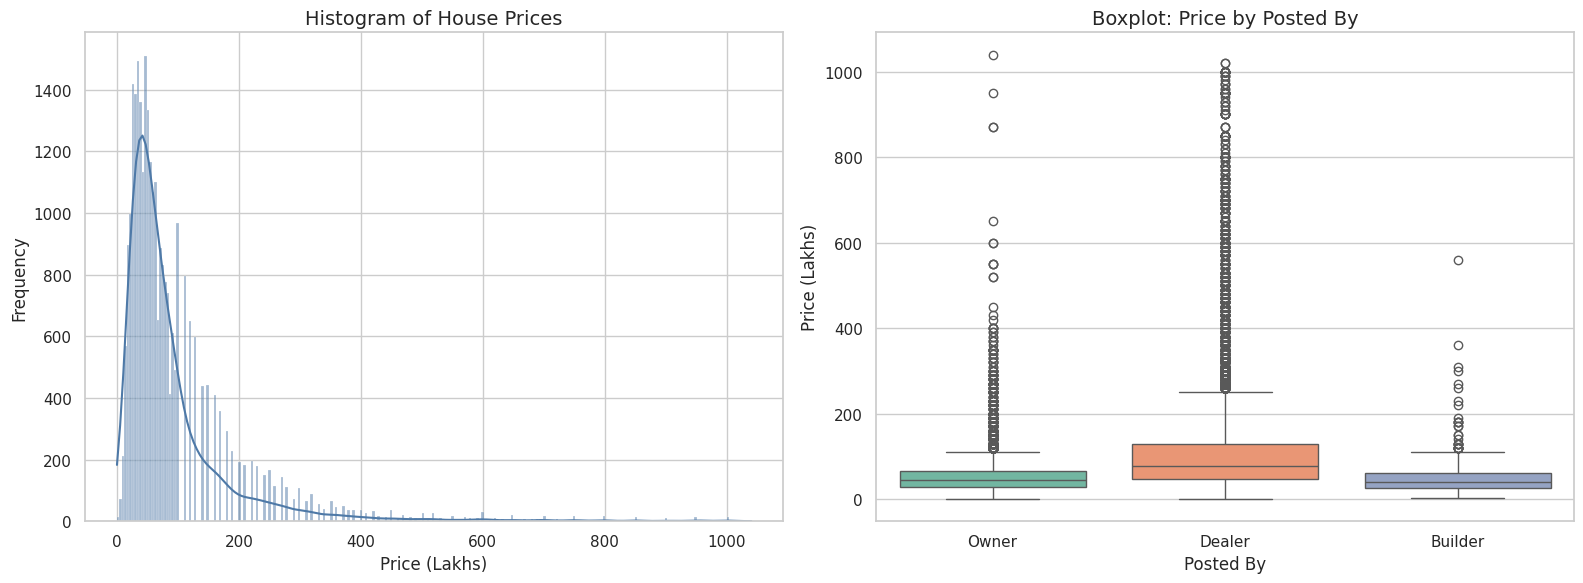

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. โหลดและทำความสะอาดข้อมูล (ใช้เกณฑ์เดียวกับตารางสถิติที่อาจารย์สรุปให้)
df = pd.read_csv('train.csv')
q_sq = df['SQUARE_FT'].quantile(0.99)
q_price = df['TARGET(PRICE_IN_LACS)'].quantile(0.99)
df_cleaned = df[(df['SQUARE_FT'] < q_sq) & (df['TARGET(PRICE_IN_LACS)'] < q_price)].copy()

# ตั้งค่าความสวยงาม
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- กราฟที่ 1: Histogram (การกระจายตัวของราคา) ---
sns.histplot(df_cleaned['TARGET(PRICE_IN_LACS)'], kde=True, ax=ax[0], color='#4e79a7')
ax[0].set_title('Histogram of House Prices', fontsize=14)
ax[0].set_xlabel('Price (Lakhs)')
ax[0].set_ylabel('Frequency')

# --- กราฟที่ 2: Boxplot (ราคาจำแนกตามผู้ลงประกาศ) ---
sns.boxplot(x='POSTED_BY', y='TARGET(PRICE_IN_LACS)', data=df_cleaned, ax=ax[1], palette='Set2')
ax[1].set_title('Boxplot: Price by Posted By', fontsize=14)
ax[1].set_xlabel('Posted By')
ax[1].set_ylabel('Price (Lakhs)')

plt.tight_layout()
plt.show()